In [1]:
import sys
import pandas as pd
import random
import math
#import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
from scipy.stats import poisson
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import special
import operator
from numpy import genfromtxt


In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (NVIDIA A100-PCIE-40GB) of compute capability 8.0 with 42.4Gb total memory.



compound poisson gamma

In [3]:
#intialization: theta is based on estimated doublet proportion; 
#               alpha and beta is estimated by assuming a simple gamma distribution and estimated by method of moment
def initialization(theta, data):
  #theta is a numerical value
  #data should be the count matrix in tensor form
  theta = torch.tensor(theta, device = dev)
  mu = torch.mean(data, dim=0)
  var = torch.var(data, dim=0)
  alpha = torch.square(mu)/var.to(dev)
  beta = mu/var.to(dev)

  theta = theta.requires_grad_()
  alpha = alpha.requires_grad_()
  beta = beta.requires_grad_()


  return theta, alpha, beta

#log likelihood
def loglik(N, theta, alpha, beta, decay, data):
  #N is the user estimated maximum number of cells in a droplet
  #theta, alpha, and beta are outputs from initialization function
  #data should be the count matrix in tensor form
  
  poisson = torch.distributions.Poisson(theta)
  for k in range(N):
    gamma = torch.distributions.Gamma(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), beta)
    if k ==0 :
      sum_k = gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp()
    else:
      sum_k = sum_k.clone() + gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp() #sum of likelihood

  l = sum_k.log().sum()
  return l

def MLE(data, N=3, p=0.7, lr=0.001, tolerance = 20):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization(theta, data)
    alpha0 = 0.5*torch.mean(alpha).to('cpu').detach().item()

    parameters = [theta, alpha, beta, decay]

    optimizer = optim.Adam(parameters, lr=lr)

    NLL_0 = -loglik(N, theta, alpha, beta, decay, x)
    l = []
    singlet_rate = []


    for i in range(5000):
        #theta = theta.clone().clamp_(0.001, 1)
        NLL = -loglik(N, theta, alpha, beta, decay, x)
        if i % 200 == 0:
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1

        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.001, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = alpha0)

    

    return theta, alpha, beta, decay, l, singlet_rate

def compound_poisson_gamma_cdf(data, alpha, beta, theta, decay, N=3):
  #calculate estimated distribution for each gene
  #grid = np.expand_dims(np.arange(0, np.max(data), 0.1), axis = 0)
  grid = np.expand_dims(np.arange(0, np.maximum(np.max(data),500), 1), axis = 0)
  grid = np.repeat(grid, data.shape[1], axis = 0)
  grid = grid.T
  
  for k in range(N):
    if k==0:
      cdf = poisson.pmf(k, theta)*(gamma.cdf(grid, alpha*torch.pow(decay, torch.arange(k+1, device = dev)).sum(), loc=0, scale=1/beta).to('cpu').detach().numpy())
    else:
      cdf += poisson.pmf(k, theta)*(gamma.cdf(grid, alpha*torch.pow(decay, torch.arange(k+1, device = dev)).sum(), loc=0, scale=1/beta).to('cpu').detach().numpy())

  return cdf

def empirical_cdf(data):
  grid = np.expand_dims(np.arange(0, np.maximum(np.max(data),100), 0.01), axis = 0)
  grid = np.repeat(grid, data.shape[1], axis = 0)
  grid = grid.T
  grid = np.expand_dims(grid, axis = 1)

  emp_cdf = np.sum(data < grid, 1)/data.shape[0]

  return emp_cdf

def goodness_of_fit(data, alpha, beta, theta, decay, N=3):

  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  data = data - 0.0001
  theta = theta.to('cpu').detach().numpy()

  diff = abs(empirical_cdf(data)-compound_poisson_gamma_cdf(data, alpha, beta, theta, decay, N))
  dn = np.max(diff, axis = 0)

  #plt.violinplot(dn)
  #plt.axhline(y = np.average(dn), color = 'r', linestyle = '--')
  
  print(dn)
  print("Distribution of Kolmogorov–Smirnov statistics across all genes")
  print("Lower values indicate better fit")






In [4]:
def log_joint_one_k(data, theta, alpha, beta, decay, k0):
  #k0 starts from 0, same interpretation as the k0 in the derivation
  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  theta = theta.to('cpu').detach().numpy()
  decay = decay.to('cpu').detach().numpy()

  alpha = alpha*(1+k0/(1+np.exp(-decay)))

  log_conditional = np.log(gamma.pdf(data, alpha, loc=0, scale=1/beta)) 
  sum_gene = np.sum(log_conditional, axis = 1)
  log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
  var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0(data, theta, alpha, beta, decay, k0, k=3):
  log_joint_k0 = log_joint_one_k(data, theta, alpha, beta, decay, k0)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k(data, theta, alpha, beta, decay, i)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)
  

  return prob

def reliability_rna(data, theta, alpha, beta, decay, k=3):
    
    
    prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k)
    prob_doublet = 1-prob_singlet
    pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = small_stable.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.pdf(data,  alpha_k, loc=0, scale=1/beta))

        

    
    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature
    #print(np.exp(one_ks[:,:,0])
    
    
    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def rna_fit_goodness(data, alpha, beta, theta, decay, k=3):
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0] #+ 1e-100 #adjust 1e-100 as needed
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.cdf(grid, alpha_k, loc=0, scale=1/beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    plt.violinplot(np.amax(diff, axis = 0))
    plt.axhline(y = mean_ks, color = 'r', linestyle = '--')
  
    print("Distribution of Kolmogorov–Smirnov statistics across all genes")
    print("Lower values indicate better fit")
    
    return mean_ks

def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    precision = np.sum(dichotomized[label==1]==1)/np.sum(dichotomized==1)
    prop = np.sum(dichotomized==1)/label.shape[0]
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    print("Predicted doublet proportion:",prop)
    print("Precision:", precision)
    print("f1 score:", f1)
    
    return sensitivity, specificity

PB-1

In [5]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220215_1/
stable = pd.read_csv("./RNA_stable500_cts.csv")

small_stable = stable.iloc[:, 1:301] #300 stable features


/ix1/wchen/Haoran/CPDD/RNA/20220215_1


In [6]:
small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)



In [7]:
theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ihome/crc/install/cuda-11.3/pytorch/1.11.0_gpu/python3.8/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /ihome/wchen/hah112/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.1847181640253362

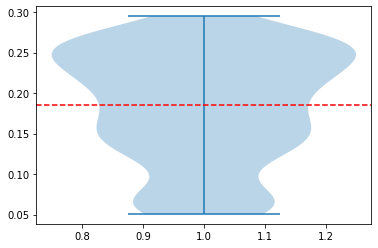

In [8]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

In [9]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)


0.7765075704343188


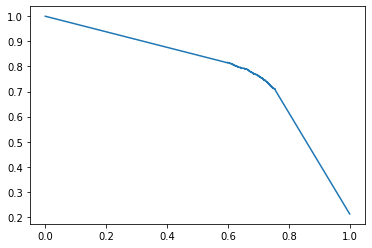

In [10]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [11]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.19567707935538073
Precision: 0.7615144418423107
f1 score: 0.7300280636108513


In [12]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)

doublet_prediction.to_csv('doublet_20220215_1_rna.csv',index=False)

In [13]:
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_1_rna.csv',index=False)

In [14]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220215_1_3.0.csv',index=False)

PB-2

In [15]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220215_2/
stable = pd.read_csv("./RNA_stable500_cts.csv")
small_stable = stable.iloc[:, 1:301] #300 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220215_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.16185876934126114

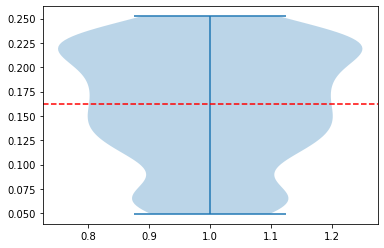

In [16]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7595207333312911


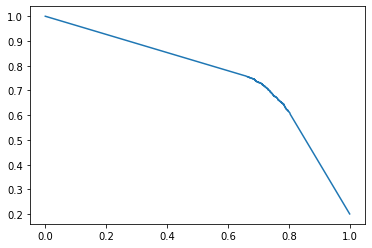

In [17]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [18]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220215_2_rna.csv',index=False)

In [19]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220215_2_rna.csv',index=False)

In [20]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.22374586549062844
Precision: 0.6763165999384047
f1 score: 0.7125243348475014


In [21]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220215_2_3.0.csv',index=False)

PB-3

In [22]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220218_1/
stable = pd.read_csv("./RNA_stable500_cts.csv")
small_stable = stable.iloc[:, 1:301] #300 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220218_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.13742311922768924

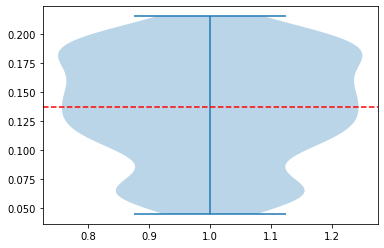

In [23]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7958282232634759


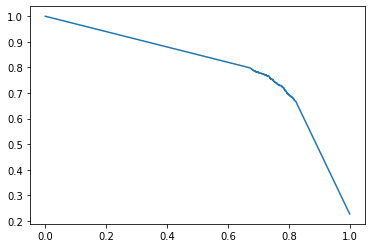

In [24]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [25]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.24003507115397585
Precision: 0.7305422871593145
f1 score: 0.7499278915488895


In [26]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_1_rna.csv',index=False)

In [27]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_1_rna.csv',index=False)

In [28]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220218_1_3.0.csv',index=False)

PB-4

In [29]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220218_2/
stable = pd.read_csv("./RNA_stable500_cts.csv")
small_stable = stable.iloc[:, 1:301] #300 stable features

small_stable = torch.tensor(small_stable.values, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220218_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.14388044005081368

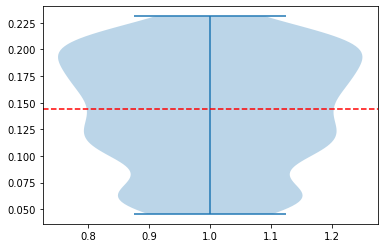

In [30]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7656751738716365


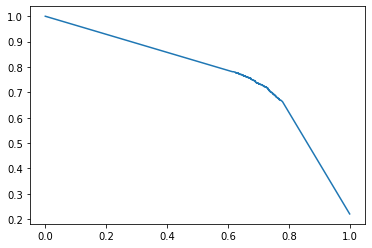

In [31]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [32]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.2229813298780847
Precision: 0.7187004754358162
f1 score: 0.7227091633466135


In [33]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220218_2_rna.csv',index=False)

In [34]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220218_2_rna.csv',index=False)

In [35]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20220218_2_3.0.csv',index=False)

Ileum-1

In [36]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230124_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230124_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.2972213420510833

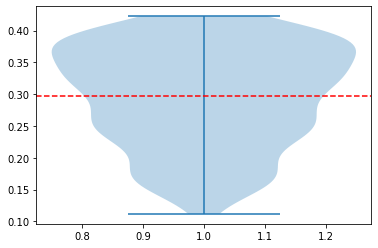

In [37]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.6457602604121981


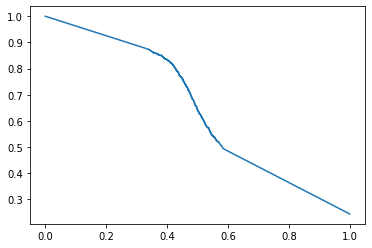

In [38]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [39]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.17353726887014823
Precision: 0.6818593419861153
f1 score: 0.5668757841907152


In [40]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_1_rna.csv',index=False)

In [41]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_1_rna.csv',index=False)

In [42]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)
prob_triplet = prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)
data = {'singlet': prob_singlet,
        'doublet': prob_doublet,
        'triplet': prob_triplet}
  
# Create DataFrame
doublet_prediction = pd.DataFrame(data)
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('All_20230124_1_3.0.csv',index=False)

Ileum-2

In [43]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230124_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230124_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.3241836096601002

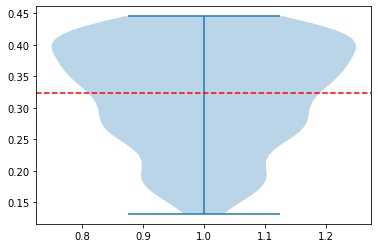

In [44]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.6584482129933837


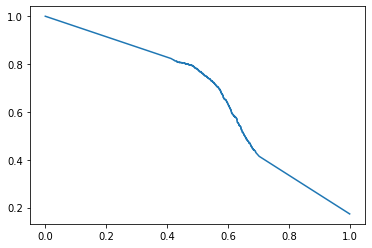

In [45]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [46]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.16866708780795958
Precision: 0.6224038134150494
f1 score: 0.6133199127663145


In [47]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230124_2_rna.csv',index=False)

In [48]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230124_2_rna.csv',index=False)

Ileum-3

In [49]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230126_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230126_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.30480474618785497

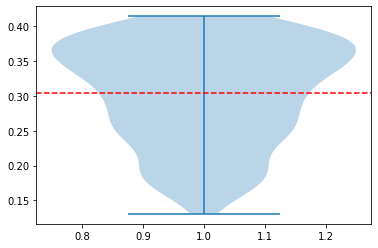

In [50]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.5028077976676018


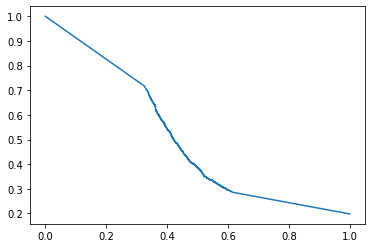

In [51]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [52]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.26233118027011154
Precision: 0.3813654168998321
f1 score: 0.4344223107569722


In [53]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_1_rna.csv',index=False)

In [54]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_1_rna.csv',index=False)

Ileum-4

In [55]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230126_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230126_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.32752815916616024

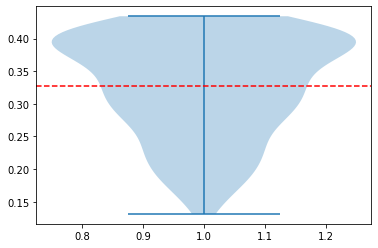

In [56]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.5137806508066549


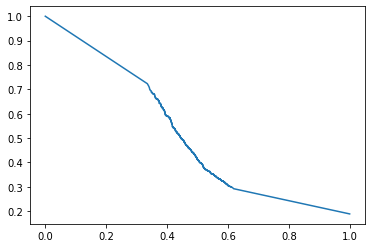

In [57]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [58]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.24738725841088047
Precision: 0.39265046296296297
f1 score: 0.445648604269294


In [59]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230126_2_rna.csv',index=False)

In [60]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230126_2_rna.csv',index=False)

Ileum-5

In [61]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230203_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230203_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.2642063552858071

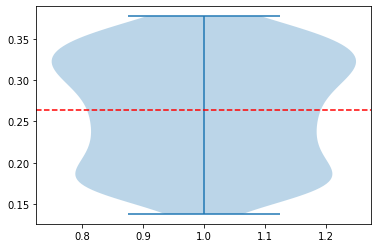

In [62]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.6168476656482167


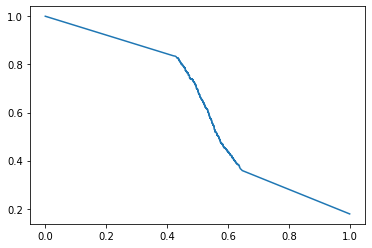

In [63]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [64]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.1799821558926109
Precision: 0.54799459215863
f1 score: 0.550101786926035


In [65]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_1_rna.csv',index=False)

In [66]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_1_rna.csv',index=False)

Ileum-6

In [67]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230203_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230203_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.2650718126739947

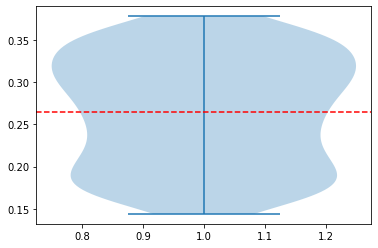

In [68]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.5914213809390796


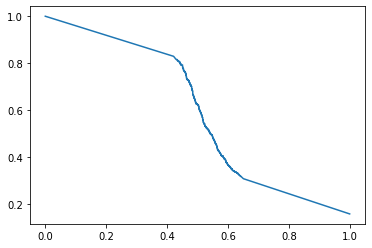

In [69]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [70]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.18341178380133094
Precision: 0.47920353982300884
f1 score: 0.5126627218934912


In [71]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230203_2_rna.csv',index=False)

In [72]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230203_2_rna.csv',index=False)

Ileum-7

In [73]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20230206_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20230206_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.29075642087950976

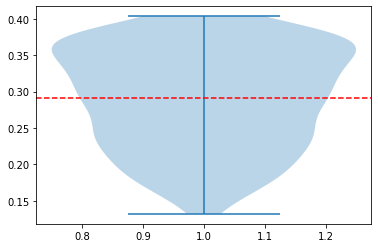

In [74]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.5864564270185175


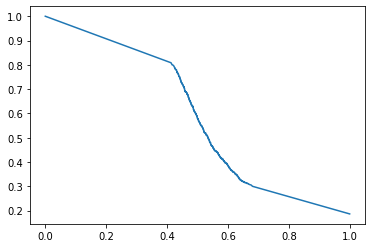

In [75]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [76]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.24558871761233192
Precision: 0.43162393162393164
f1 score: 0.49073792894017615


In [77]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20230206_2_rna.csv',index=False)

In [78]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20230206_2_rna.csv',index=False)

PB-5

In [79]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220429_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220429_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.23839004520945611

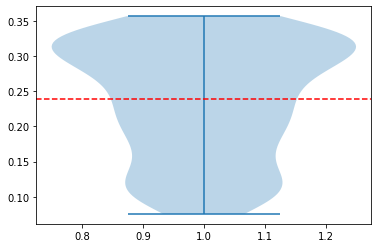

In [80]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7447600682313715


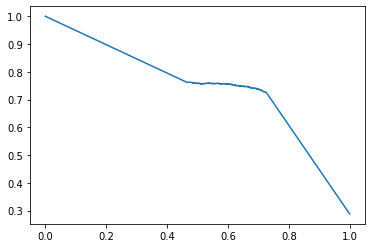

In [81]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [82]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.24583024003959417
Precision: 0.749345681497886
f1 score: 0.6898980537534755


In [83]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_1_rna.csv',index=False)

In [84]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_1_rna.csv',index=False)

PB-6

In [85]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220429_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220429_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.22774763189812944

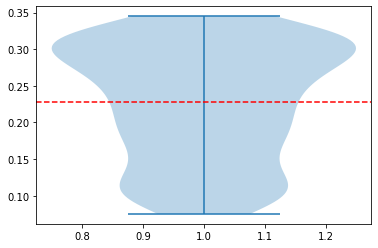

In [86]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7792853206814155


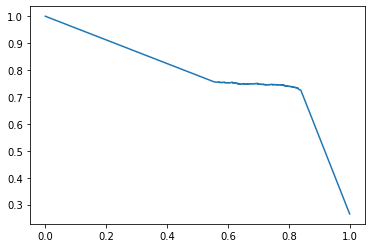

In [87]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [88]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.2650595941157522
Precision: 0.7464046992100466
f1 score: 0.7458759234895254


In [89]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_2_rna.csv',index=False)

In [90]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_2_rna.csv',index=False)

PB-7

In [91]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220429_3/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220429_3


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.24442882948105138

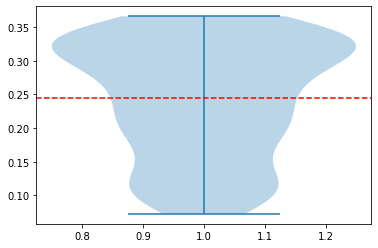

In [92]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7667178184719952


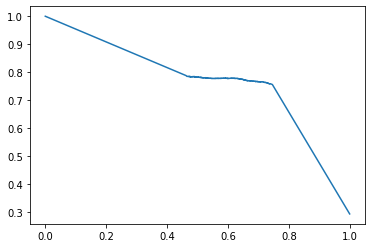

In [93]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [94]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.24477495868571983
Precision: 0.7756155679110405
f1 score: 0.7042913811756221


In [95]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220429_3_rna.csv',index=False)

In [96]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220429_3_rna.csv',index=False)

PB-8

In [97]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220524_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220524_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.18165049358336038

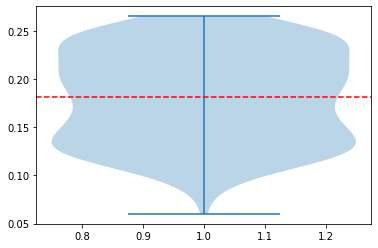

In [98]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.8350756033075539


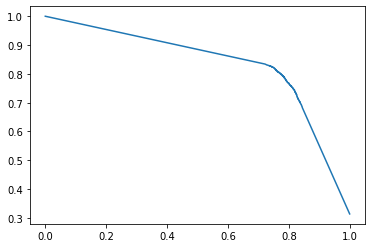

In [99]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [100]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)

Predicted doublet proportion: 0.33665118336651184
Precision: 0.7550591327201052
f1 score: 0.7814497484020128


In [101]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_1_rna.csv',index=False)

In [102]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_1_rna.csv',index=False)

PB-9

In [103]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20220524_2/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20220524_2


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.19002912537746833

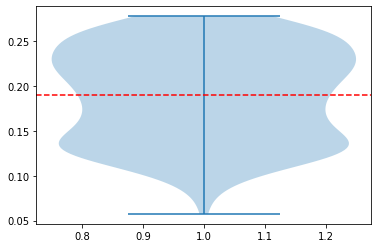

In [104]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.843007132005038


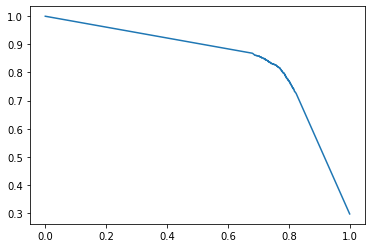

In [105]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [106]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.2910104817473021
Precision: 0.7984386089425124
f1 score: 0.7903055848261327


In [107]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20220524_2_rna.csv',index=False)

In [108]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20220524_2_rna.csv',index=False)

PB-10

In [109]:
%cd /ix1/wchen/Haoran/CPDD/RNA/20210831_1/
stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
small_stable = stable[:,0:300]

small_stable = torch.tensor(small_stable, device = dev)
small_stable = small_stable.double()
small_stable = small_stable + torch.tensor([0.0001], device = dev)


theta,alpha,beta,decay, loss_075,p_075 = MLE(small_stable)

/ix1/wchen/Haoran/CPDD/RNA/20210831_1


Distribution of Kolmogorov–Smirnov statistics across all genes
Lower values indicate better fit


0.17059472803422443

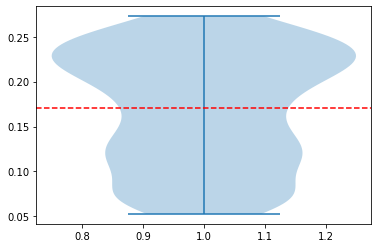

In [110]:
weight = rna_fit_goodness(small_stable, alpha, beta, theta, decay)
weight

0.7199197509178692


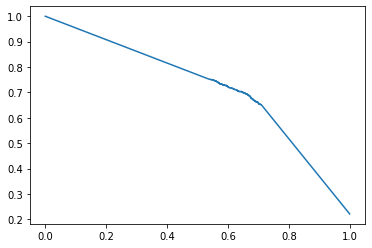

In [111]:
prob_singlet = prob_k0(small_stable, theta, alpha, beta, decay, 0, k=3)
prob_doublet = 1-prob_singlet
#prob_doublet = doublet_pred(small_stable, theta, alpha, beta, decay, k=3)
#prob_doublet = prob_k0(small_stable, theta, alpha, beta, decay, 1, k=3)+prob_k0(small_stable, theta, alpha, beta, decay, 2, k=3)

doublet = genfromtxt("./doublet.csv", delimiter=',')
doublet = doublet[1:, 1]
#doublet = doublet.iloc[:, 1]
#prob_doublet = np.nan_to_num(prob_doublet, nan=1.0)


precision, recall, thresholds = precision_recall_curve(doublet, prob_doublet)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [112]:
sen, spe = metrics(prob_doublet, doublet, cut = 0.5)


Predicted doublet proportion: 0.20802120548576697
Precision: 0.6975069252077563
f1 score: 0.6751575278187425


In [113]:
doublet_prediction = pd.DataFrame(prob_doublet, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
doublet_prediction.to_csv('doublet_20210831_1_rna.csv',index=False)

In [114]:
reliability_table = reliability_rna(small_stable, theta, alpha, beta, decay)
data = {'reliability': reliability_table[0,:]/weight,
        'flag': reliability_table[1,:]}
  
# Create DataFrame
reliability_file = pd.DataFrame(data)
reliability_file.index.name = 'index'
reliability_file.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
reliability_file.to_csv('reliability_20210831_1_rna.csv',index=False)